# Fake News Detection Using Bert

## Loading Libraries

In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import time


## Enabling GPU (CUDA)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## Loading the dataset

In [18]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

## Adding Labels

In [19]:
fake_df["label"] = 0
true_df["label"] = 1

## Merging

In [20]:
df = pd.concat([fake_df, true_df]).sample(frac=1).reset_index(drop=True)

## Initializing the tokenizer

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

## Custom Dataset Class

In [23]:
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.texts = df["title"] + " " + df["text"]
        self.labels = df["label"].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

## Dataset preparation

In [24]:
dataset = NewsDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

## Creating Dataloaders

In [25]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Load the pretrained model

In [26]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining Optimizers and Scheduler

In [28]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loss function

In [29]:
loss_fn = nn.CrossEntropyLoss()

## Setting up Mixed Precision Training (AMP)

In [30]:
scaler = GradScaler()
gradient_accumulation_steps = 2

<ipython-input-30-5a3b1caa1b37>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Training

In [31]:
epochs = 3
start_time = time.time()
train_losses = []

In [32]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            with autocast():
                outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
                loss = outputs.loss
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    return total_loss / len(test_loader), correct / total * 100

accuracies = []

In [33]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {key: val.to(device) for key, val in batch.items()}
        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
            loss = outputs.loss / gradient_accumulation_steps
        scaler.scale(loss).backward()
        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    test_loss, test_acc = evaluate(model, test_loader)
    accuracies.append(test_acc)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_loss:.4f}, Test Accuracy = {test_acc:.2f}%")


<ipython-input-33-375077c456ea>:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-32-497b87b039f7>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss = 0.0086, Test Accuracy = 99.96%
Epoch 2: Train Loss = 0.0023, Test Accuracy = 99.94%
Epoch 3: Train Loss = 0.0004, Test Accuracy = 99.97%


## Saving the model

In [34]:
model.save_pretrained("fake_news_model")
tokenizer.save_pretrained("fake_news_model")

('fake_news_model/tokenizer_config.json',
 'fake_news_model/special_tokens_map.json',
 'fake_news_model/vocab.txt',
 'fake_news_model/added_tokens.json')

## Plotting

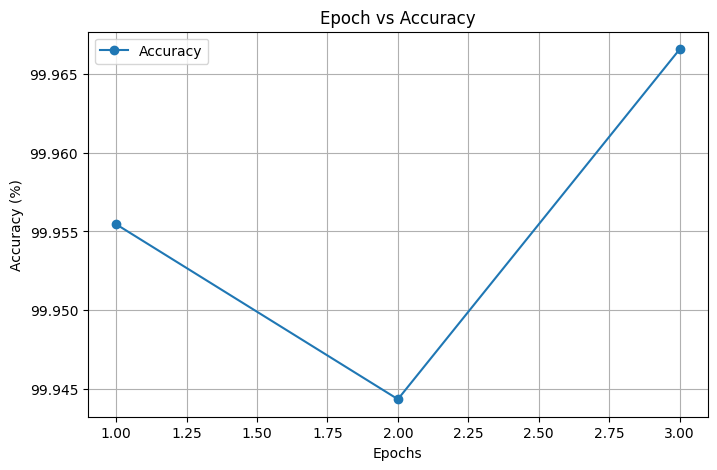

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), accuracies, marker='o', linestyle='-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid()
plt.show()

## Inference Function

In [36]:
def predict(text):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return "Fake News" if pred == 0 else "True News"

## Example Prediction

In [37]:
print(predict("Breaking: Scientists discover a new element on Mars!"))

Fake News
